In [1]:
from pypfopt.efficient_frontier import EfficientFrontier
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
SP500 = pd.read_csv('/Users/malek/Documents/WRDS Data/S&P 500 Monthly Returns.csv',index_col=0,parse_dates=True)
data = pd.read_csv('/Users/malek/Documents/WRDS Data/Diversifiers.csv',index_col=0)[['Barclays Aggregate Bond','BTOP50']]
data.index = pd.to_datetime(data.index,dayfirst=True)
data = data.pct_change()
data = data[35:-6].resample('M').last()
data = data.merge(SP500,left_index=True,right_index=True,how='inner')
data.columns = ['Bloomberg Agg Bond','BTOP50','S&P500']
data

,Bloomberg Agg Bond,BTOP50,S&P500
1993-01-31,0.017163,-0.009051,0.000000
1993-02-28,0.015791,0.068745,0.010669
1993-03-31,0.010849,-0.004814,0.017593
1993-04-30,0.014336,0.031716,-0.025588
1993-05-31,0.006806,0.012490,0.026969
...,...,...,...
2022-08-31,-0.039461,0.014924,-0.040802
2022-09-30,-0.051380,0.040763,-0.096159
2022-10-31,-0.006877,0.010372,0.081276
2022-11-30,0.047061,-0.049728,0.055592


In [3]:
data.corr()

,Bloomberg Agg Bond,BTOP50,S&P500
Bloomberg Agg Bond,1.000000,0.152652,0.235413
BTOP50,0.152652,1.000000,-0.077491
S&P500,0.235413,-0.077491,1.000000


In [4]:
Tangency_Portfolio = EfficientFrontier(data.mean()*12,data.cov()*12,weight_bounds=(0,1))
Tangency_Portfolio.add_constraint(lambda w: w[0]+w[1]+w[2]
== 1)
weights = Tangency_Portfolio.max_sharpe(risk_free_rate=0.0)
weights = Tangency_Portfolio.clean_weights()
Tangency_Portfolio.portfolio_performance(verbose=True)
weights

Expected annual return: 5.3%
Annual volatility: 5.1%
Sharpe Ratio: 1.05


OrderedDict([('Bloomberg Agg Bond', 0.46121),
             ('BTOP50', 0.38221),
             ('S&P500', 0.15658)])

In [5]:
MVOweights = []
for i in data.columns:
    MVOweights.append(weights[i])

MVO = ((data*MVOweights).sum(axis=1))
data['Mean Variance'] = MVO

In [6]:
# Normalised to 15% Volatility
for i in data.columns:
    std = data[i].std()*(12**0.5)
    scailer = 0.15/std
    data[i] = data[i]*scailer

In [7]:
def sharpe(x):
    A = x.mean()*12 
    R = x.std()*(12**0.5)
    sharpe = A/R
    return sharpe
# Sharpe Ratios Since Jan 1st 1993
data.expanding(1).apply(sharpe).iloc[-1]

Bloomberg Agg Bond    0.738971
BTOP50                0.684275
S&P500                0.557898
Mean Variance         1.047927
Name: 2022-12-31 00:00:00, dtype: float64

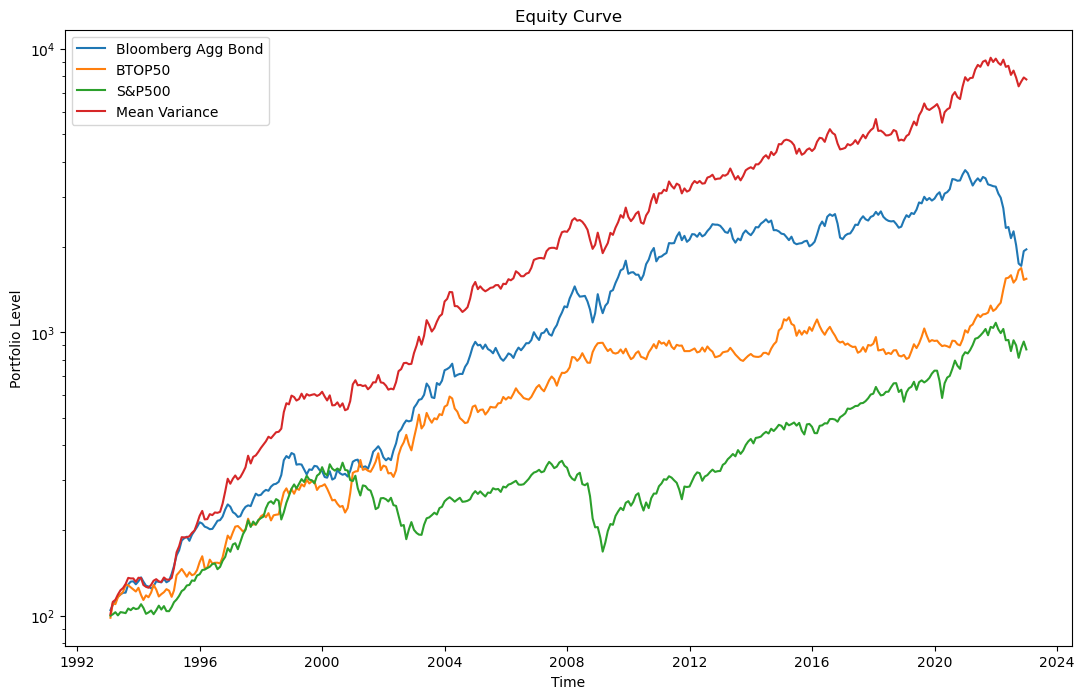

In [8]:
fig = plt.figure(figsize=(13,8))
plt.plot(data.index,100*(data+1).cumprod(),label=data.columns)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Portfolio Level')
plt.title('Equity Curve')
plt.yscale('log')
plt.show()